-------------------0805+2818a-------------------
plate-mjd-fiber: 929 52581 570
redshift: 0.1284
flux normalized by: 26.896444
Emission lines included in gas templates:
['Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[OII]3726' '[OII]3729' '[SII]6716'
 '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:        14       298     0.119     0.206
 comp. 1:       -91       324    -0.012     0.262
 comp. 2:       -66       302    -0.114     0.096
chi2/DOF: 0.01441
method = capfit ; Jac calls: 12 ; Func calls: 282 ; Status: 2
Nonzero Templates:  136  /  161
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1        Hdelta      2.555       3.1     -91   324
Comp: 1        Hgamma      7.105       3.2     -91   324
Comp: 1         Hbeta       14.5       3.8     -91   324
Comp: 1        Halpha      58.69       6.7     

M/L_r: 1.814
L r band (erg/s): 43.28
Log Stellar mass (solar mass) [2.78865607e+09]
mass frac tion below 10^8 yr: 0.02343
SFR (M_sun/yr):  [0.65329713]
SFR_err:  [0.05383544]
-------------------1058+3144b-------------------
plate-mjd-fiber: 2026 53711 17
redshift: 0.0723
flux normalized by: 31.032597
Emission lines included in gas templates:
['Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[OII]3726' '[OII]3729' '[SII]6716'
 '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:      -103       177     0.040     0.048
 comp. 1:      -168       155     0.048    -0.034
 comp. 2:      -133       163    -0.013     0.013
chi2/DOF: 0.006743
method = capfit ; Jac calls: 8 ; Func calls: 189 ; Status: 2
Nonzero Templates:  130  /  161
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1        Hdelta      1.889       2.7 

M/L_r: 2.945
L r band (erg/s): 42.62
Log Stellar mass (solar mass) [3.70242067e+08]
mass frac tion below 10^8 yr: 0
SFR (M_sun/yr):  [0.]
SFR_err:  [0.]


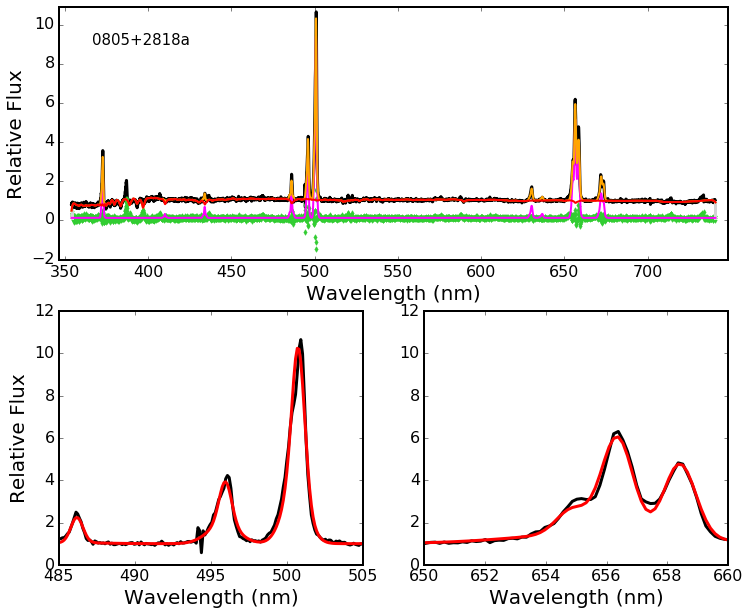

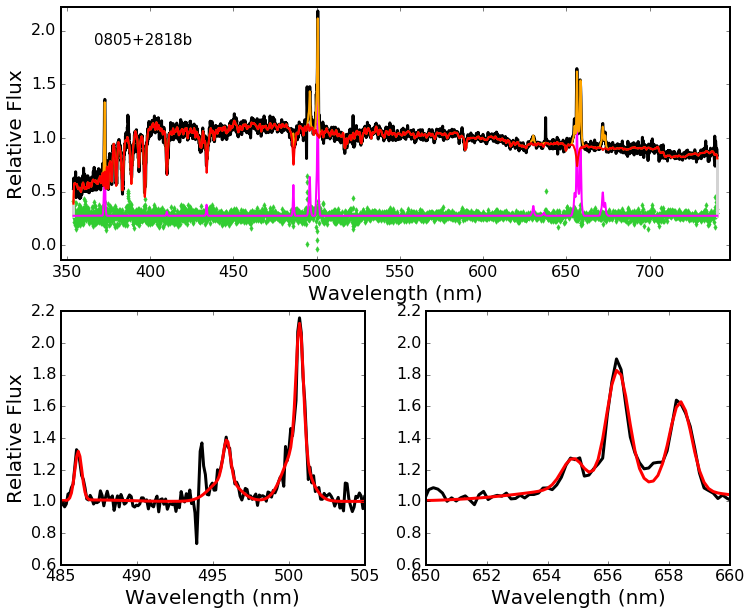

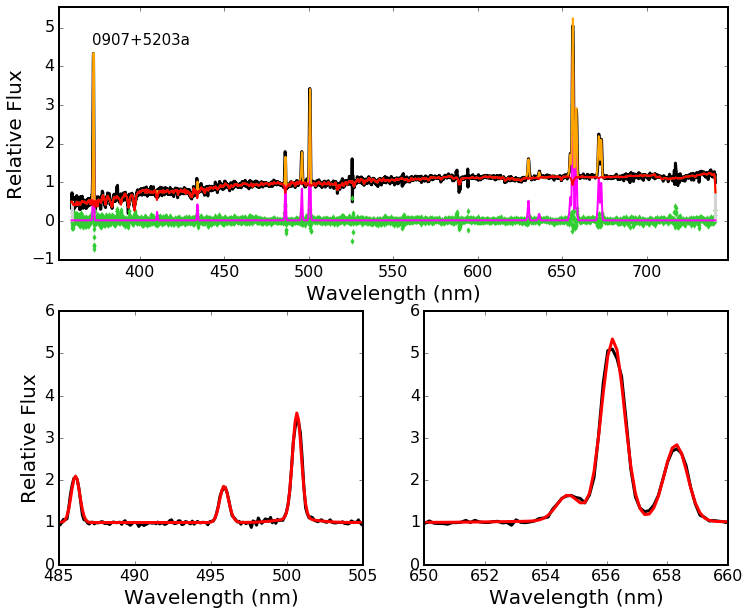

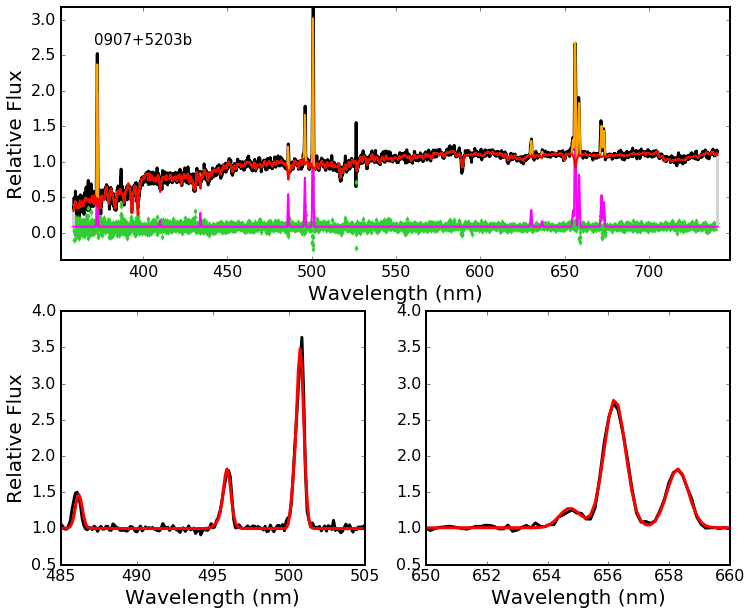

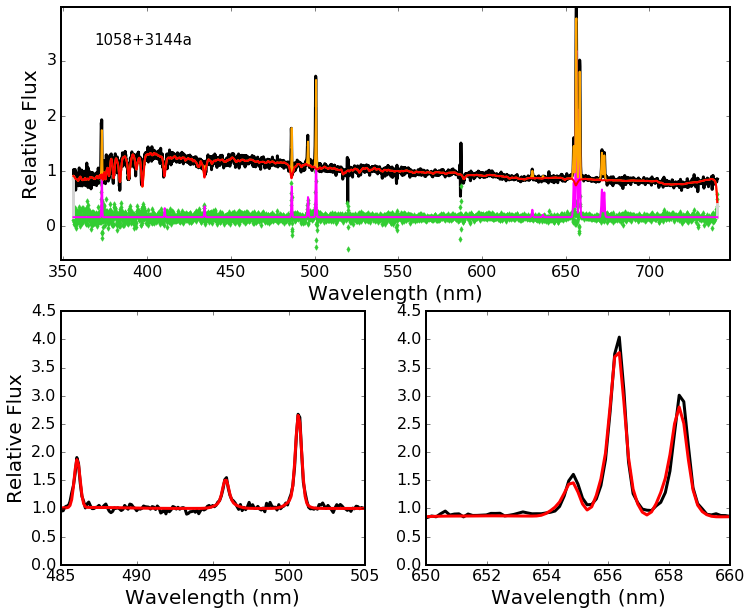

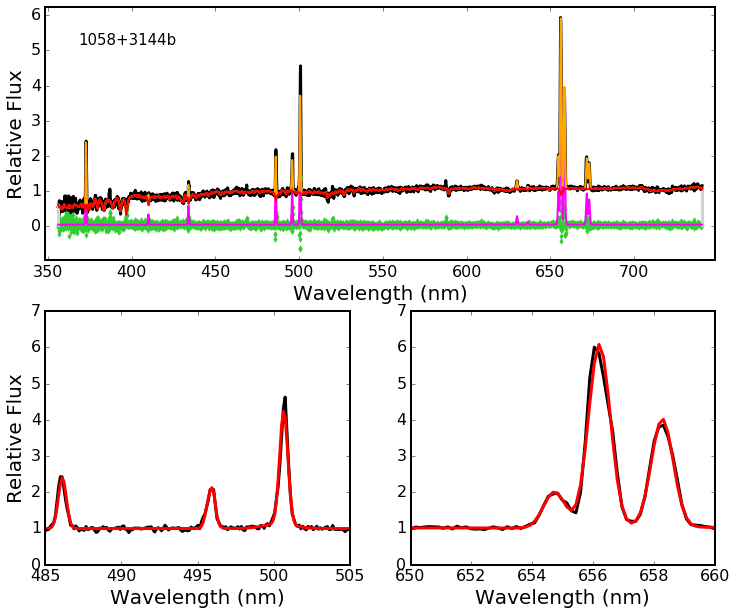

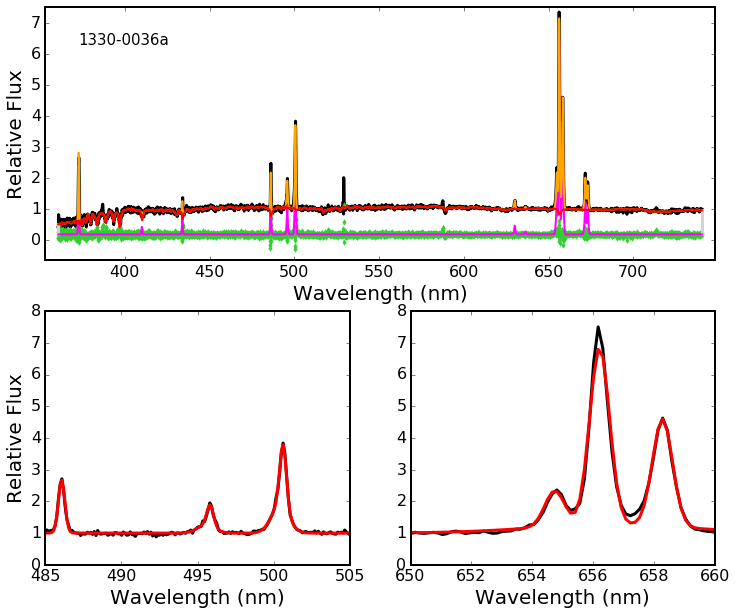

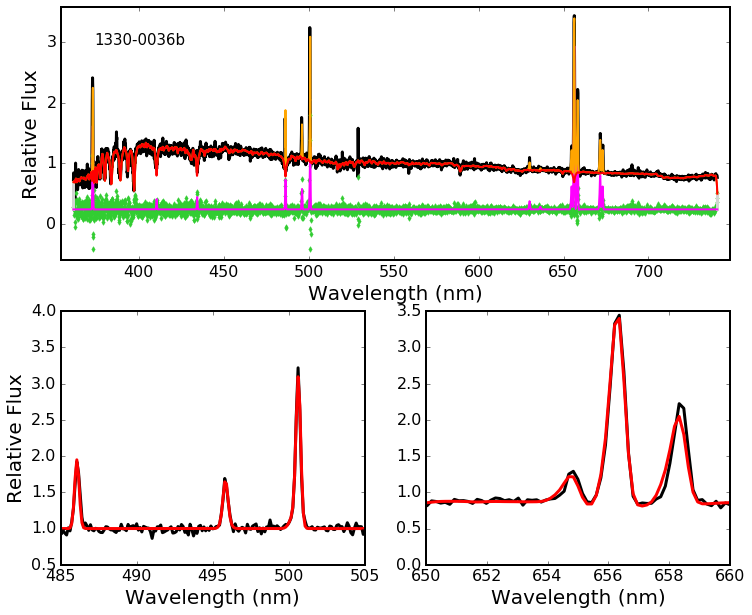

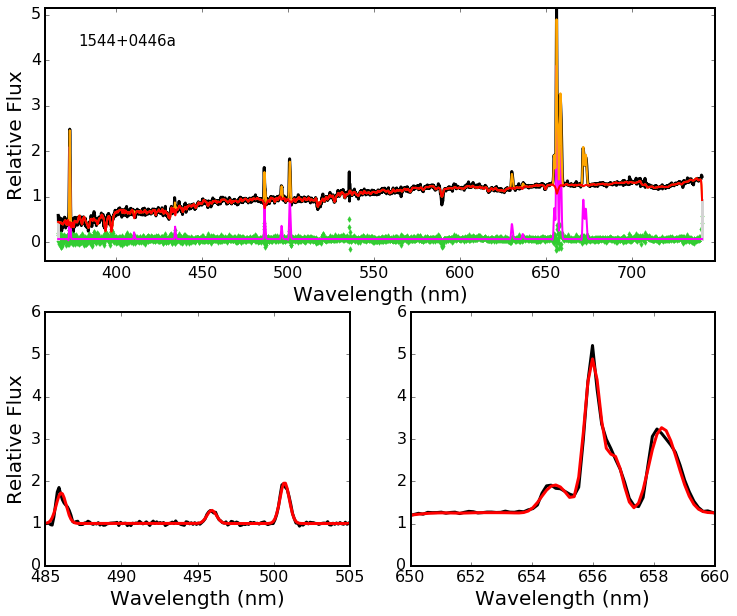

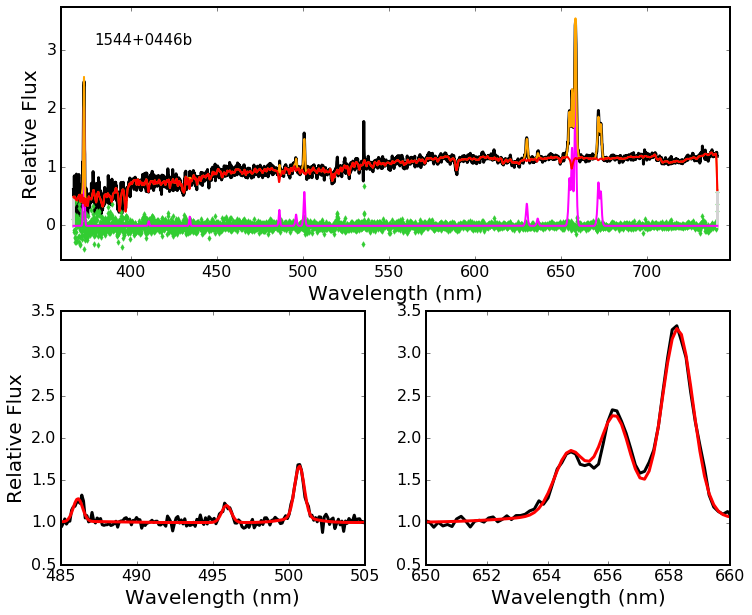

In [134]:
%matplotlib inline
# %load ppxf_example_population_gas_sdss.py
#!/usr/bin/env python
##############################################################################
#
# Usage example for the procedure PPXF, which implements the
# Penalized Pixel-Fitting (pPXF) method originally described in
# Cappellari M., & Emsellem E., 2004, PASP, 116, 138
#     http://adsabs.harvard.edu/abs/2004PASP..116..138C
# and upgraded in Cappellari M., 2017, MNRAS, 466, 798
#     http://adsabs.harvard.edu/abs/2017MNRAS.466..798C
#
# This example shows how to study stellar population and include gas emission
# lines as templates instead of masking them using the GOODPIXELS keyword.
#


##############################################################################



from astropy.cosmology import FlatLambdaCDM
from time import clock
from os import path
import glob, os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.miles_util as lib

##############################################################################
def flux2L(flux,z):
    """Transfer flux to luminoity assuming a flat Universe"""
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    DL = cosmo.luminosity_distance(z).value*10**6*3.08*10**18 # unit cm
    L = flux*1.e-17*4.*np.pi*DL**2   #erg/s/A
    return L

def L_conti(wave,flux,z):
    return np.asarray([np.log10(5100*flux2L(flux[np.where( abs(wave - 5100.) < 5.,True,False)].mean(),z) )])
    


tie_balmer=False
limit_doublets=False
ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))

# Read SDSS DR8 galaxy spectrum taken from here http://www.sdss3.org/dr8/
# The spectrum is *already* log rebinned by the SDSS DR8
# pipeline and log_rebin should not be used in this case.
#
#file = ppxf_dir + '/spectra/NGC3522_SDSS_DR8.fits'

mass_frac_all = np.array([])
ml_all = np.array([])
L_all = np.array([])
for i in zip(glob.glob('/Users/legolason/study/otherwork/meicun/data/*.fits'),\
                range(10),['0805+2818a','0805+2818b','0907+5203a','0907+5203b',\
                    '1058+3144a','1058+3144b','1330-0036a','1330-0036b','1544+0446a','1544+0446b']):
#for i in zip(glob.glob('/Users/legolason/study/otherwork/meicun/data/13b*.fits'),\
#            range(1),['1330-0036b']):

    print '-------------------'+i[2]+'-------------------'
    hdu = fits.open(i[0])
    t = hdu[1].data
    wv = 10**t['loglam']
    redshift = float(hdu[2].data['z'])
    print 'plate-mjd-fiber:', hdu[2].data['plate'][0],hdu[2].data['mjd'][0],hdu[2].data['fiberid'][0]
    print 'redshift:',np.round(redshift,4)
    
    wave1 = 10**t['loglam']/(1.+ redshift)
    flux1 = t['flux']
    err1 = 1./np.sqrt(t['ivar'])
    z = 0.

    # Only use the wavelength range in common between galaxy and stellar library.
    #
    mask = np.where( (wave1 > 3541.) & (wave1 < 7409.) & (err1 <100.), True, False)

    flux = flux1[mask]
    galaxy = flux/np.median(flux)   # Normalize spectrum to avoid numerical issues
    factor1=np.median(flux)
    print 'flux normalized by:', np.median(flux)
    wave = wave1[mask]
    err = err1[mask]



    # The SDSS wavelengths are in vacuum, while the MILES ones are in air.
    # For a rigorous treatment, the SDSS vacuum wavelengths should be
    # converted into air wavelengths and the spectra should be resampled.
    # To avoid resampling, given that the wavelength dependence of the
    # correction is very weak, I approximate it with a constant factor.
    #
    wave *= np.median(util.vac_to_air(wave)/wave)


    # The noise level is chosen to give Chi^2/DOF=1 without regularization (REGUL=0).
    # A constant noise is not a bad approximation in the fitted wavelength
    # range and reduces the noise in the fit.
    #
    #noise = np.full_like(galaxy, 0.01635)  # Assume constant noise per pixel here
    noise = err*0.5

    # The velocity step was already chosen by the SDSS pipeline
    # and we convert it below to km/s
    #
    c = 299792.458  # speed of light in km/s
    velscale = c*np.log(wave[1]/wave[0])  # eq.(8) of Cappellari (2017)
    FWHM_gal = 2.76  # SDSS has an approximate instrumental resolution FWHM of 2.76A.

    #------------------- Setup templates -----------------------

    pathname = ppxf_dir + '/miles_models/Mun1.30*.fits'
    miles = lib.miles(pathname, velscale, FWHM_gal)


    # The stellar templates are reshaped below into a 2-dim array with each
    # spectrum as a column, however we save the original array dimensions,
    # which are needed to specify the regularization dimensions
    #
    reg_dim = miles.templates.shape[1:]
    stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)

    # See the pPXF documentation for the keyword REGUL,
    regul_err = 0.01  # Desired regularization error

    # Construct a set of Gaussian emission line templates.
    # Estimate the wavelength fitted range in the rest frame.
    #
    lam_range_gal = np.array([np.min(wave), np.max(wave)])/(1. + z)
    gas_templates, gas_names, line_wave = util.emission_lines(
        miles.log_lam_temp, lam_range_gal, FWHM_gal,
        tie_balmer=tie_balmer, limit_doublets=limit_doublets)

    # Combines the stellar and gaseous templates into a single array.
    # During the PPXF fit they will be assigned a different kinematic
    # COMPONENT value
    #

    templates = np.column_stack([stars_templates, gas_templates])

    #-----------------------------------------------------------

    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below as described
    # in PPXF_EXAMPLE_KINEMATICS_SAURON and Sec.2.4 of Cappellari (2017)
    #
    c = 299792.458
    dv = c*(miles.log_lam_temp[0] - np.log(wave[0]))  # eq.(8) of Cappellari (2017)
    vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
    start = [vel, 180.]  # (km/s), starting guess for [V, sigma]

    n_temps = stars_templates.shape[1]
    n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
    n_balmer = len(gas_names) - n_forbidden

    # Assign component=0 to the stellar templates, component=1 to the Balmer
    # gas emission lines templates and component=2 to the forbidden lines.
    component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
    gas_component = np.array(component) > 0  # gas_component=True for gas templates

    # Fit (V, sig, h3, h4) moments=4 for the stars
    # and (V, sig) moments=2 for the two gas kinematic components
    moments = [4, 4, 4]

    # Adopt the same starting value for the stars and the two gas components
    start = [start, start, start]

    # If the Balmer lines are tied one should allow for gas reddeining.
    # The gas_reddening can be different from the stellar one, if both are fitted.
    gas_reddening = 0 if tie_balmer else None

    # Here the actual fit starts.
    #
    # IMPORTANT: Ideally one would like not to use any polynomial in the fit
    # as the continuum shape contains important information on the population.
    # Unfortunately this is often not feasible, due to small calibration
    # uncertainties in the spectral shape. To avoid affecting the line strength of
    # the spectral features, we exclude additive polynomials (DEGREE=-1) and only use
    # multiplicative ones (MDEGREE=10). This is only recommended for population, not
    # for kinematic extraction, where additive polynomials are always recommended.
    #
    t = clock()
    pp = ppxf(templates, galaxy, noise, velscale, start,
              plot=False, moments=moments, degree=-1, mdegree=10, vsyst=dv,
              lam=wave, clean=False, regul=1./regul_err, reg_dim=reg_dim,
              component=component, gas_component=gas_component,
              gas_names=gas_names, gas_reddening=gas_reddening)

    # When the two Delta Chi^2 below are the same, the solution
    # is the smoothest consistent with the observed spectrum.
    #
    print('Desired Delta Chi^2: %.4g' % np.sqrt(2*galaxy.size))
    print('Current Delta Chi^2: %.4g' % ((pp.chi2 - 1)*galaxy.size))
    print('Elapsed time in PPXF: %.2f s' % (clock() - t))

    weights = pp.weights[~gas_component]  # Exclude weights of the gas templates
    weights = weights.reshape(reg_dim)/weights.sum()  # Normalized

    miles.mean_age_metal(weights)
    miles.mass_to_light(weights, band="r")

    # Plot fit results for stars and gas.
    #plt.clf()
    line=np.genfromtxt('/Users/legolason/study/otherwork/meicun/data_line/line_'+i[2]+'.txt')
    plt.figure(figsize=(12,10))
    plt.style.use('my')
    ax1=plt.subplot(2,2,(1,2))
    pp.plot()
    plt.text(0.05, 0.85,i[2], transform=ax1.transAxes,fontsize=15)
    
    #add the difference of the emission lines
    if i[2] == '1058+3144a': 
        for j in zip([4800,4900,5000],[4900,5000,5100],[0.8,2,1]):
            ind=np.where( (pp.lam > j[0]) & (pp.lam < j[1]), True,False)
            add=((line[:,2][ind]/factor1+1.).max()-pp.bestfit[ind].max())*j[2]
            ind2=np.argmax(pp.bestfit[ind])
            plt.plot(pp.lam[ind][ind2-1:ind2+2]/10.,pp.bestfit[ind][ind2]+[0,add,0],'orange',lw=2)
    if i[2] == '1330-0036b': 
        for j in zip([4800,4900,5000],[4900,5000,5100],[0.9,1,1]):
            ind=np.where( (pp.lam > j[0]) & (pp.lam < j[1]), True,False)
            add=((line[:,2][ind]/factor1+1.).max()-pp.bestfit[ind].max())*j[2]
            ind2=np.argmax(pp.bestfit[ind])
            plt.plot(pp.lam[ind][ind2-1:ind2+2]/10.,pp.bestfit[ind][ind2]+[0,add,0],'orange',lw=2)
    
    
    # Plot stellar population mass fraction distribution
    
    plt.subplot(223)
    plt.plot(line[:,0]/10.,line[:,1]/factor1+1,'k')
    #plt.plot(pp.lam/10.,pp.bestfit,'r')
    plt.plot(line[:,0]/10.,line[:,2]/factor1+1,'r')
    
    plt.xlim(485,505)
    plt.ylabel('Relative Flux')
    plt.xlabel('Wavelength (nm)')
    
    plt.subplot(224)
    
    #plt.plot(pp.lam/10.,pp.bestfit,'r')
    if i[2] == '1544+0446a':  
        plt.plot(pp.lam/10.,pp.galaxy,'k')
        plt.plot(pp.lam/10.,pp.bestfit,'r')
    elif i[2] == '1330-0036b':  
        plt.plot(pp.lam/10.,pp.galaxy,'k')
        plt.plot(pp.lam/10.,pp.bestfit,'r')
    elif i[2] == '1058+3144a':  
        plt.plot(pp.lam/10.,pp.galaxy,'k')
        plt.plot(pp.lam/10.,pp.bestfit,'r')
    else:
        plt.plot(line[:,0]/10.,line[:,1]/factor1+1,'k')
        plt.plot(line[:,0]/10.,line[:,2]/factor1+1,'r')
    plt.xlim(650,660)
    plt.xlabel('Wavelength (nm)')
    
    #plt.subplot(3,2,(5,6))
    
    #miles.plot(weights)
    #plt.tight_layout()
    
    
    L = L_conti(wave,flux,redshift)
    L_all = np.concatenate([L_all,L])
    
    mass_frac_tmp = np.asarray([np.sum(weights[0:3,:])])
    mass_frac_tmp_delta =np.asarray([np.sum(weights[0:4,:])-np.sum(weights[0:3,:] )]) 
    mass_frac_all = np.concatenate([mass_frac_all,mass_frac_tmp])
    
    ml_tmp = np.asarray([miles.mass_to_light(weights, band="r")])
    ml_all = np.concatenate([ml_all,ml_tmp])
    
    #print L_tmp,mass_frac_all,ml_all
    print('L r band (erg/s): %.4g' % L)
    print 'Log Stellar mass (solar mass)', 10**L/(3.8*10**33)/ml_tmp
    print('mass frac tion below 10^8 yr: %.4g' % (mass_frac_tmp))
    print 'SFR (M_sun/yr): ', (10**L/(3.8*10**33)/ml_tmp*mass_frac_tmp/10**8)
    print 'SFR_err: ', (10**L/(3.8*10**33)/ml_tmp*mass_frac_tmp_delta/10**8)
    
    
    plt.savefig('/Users/legolason/study/otherwork/meicun/fig/'+i[2]+'.eps')
    #wave=wave
    #line_flux = flux-(pp.bestfit-pp.gas_bestfit)*np.median(flux)
    #err = err
    #np.savetxt('/Users/legolason/study/otherwork/meicun/data_line/'+i[2]+'.txt',np.c_[wave,line_flux,err])



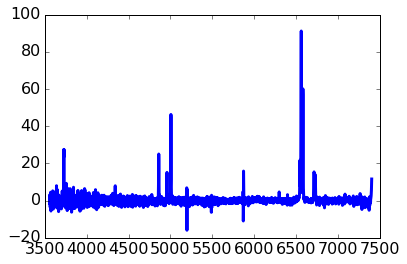

In [8]:
#plt.plot(wave,flux-(pp.bestfit-pp.gas_bestfit)*np.median(flux) ) 

wave=wave
line_flux = flux-(pp.bestfit-pp.gas_bestfit)*np.median(flux)
err = err

np.savetxt('/Users/legolason/study/otherwork/meicun/10a.txt',np.c_[wave,line_flux,err])

In [50]:

path='/Users/legolason/study/mesfit/'

newdata = np.rec.array([(6564.61,'Ha',6400.,6800.,'Ha_br',1,5e-3,0.002,0.05,0.015,0,0,0,0.05,1),\
                        (6564.61,'Ha',6400.,6800.,'Ha_na',1,1e-3,5e-4,0.002,0.01,1,1,0,0.002,1),\
                        (6549.85,'Ha',6400.,6800.,'NII6549',1,1e-3,2.3e-4,0.002,5e-3,1,1,1,0.001,1),\
                        (6585.28,'Ha',6400.,6800.,'NII6585',1,1e-3,2.3e-4,0.002,5e-3,1,1,1,0.003,1),\
                        (6718.29,'Ha',6400.,6800.,'SII6718',1,1e-3,2.3e-4,0.002,5e-3,1,1,2,0.001,1),\
                        (6732.67,'Ha',6400.,6800.,'SII6732',1,1e-3,2.3e-4,0.002,5e-3,1,1,2,0.001,1),\
                        (4862.68,'Hb',4640.,5100.,'Hb_br',3,5e-3,0.002,0.05,0.01,0,0,0,0.01,1),\
                        (4862.68,'Hb',4640.,5100.,'Hb_na',1,1e-3,2.3e-4,0.002,0.01,1,1,0,0.002,1),\
                        (4960.30,'Hb',4640.,5100.,'OIII4959c',1,1e-3,2.3e-4,0.002,0.01,1,1,0,0.002,1),\
                        (5008.24,'Hb',4640.,5100.,'OIII5007c',1,1e-3,2.3e-4,0.002,0.01,1,1,0,0.004,1),\
                        (4960.30,'Hb',4640.,5100.,'OIII4959w',1,3e-3,2.3e-4,0.004,0.01,0,0,0,0.001,1),\
                        (5008.24,'Hb',4640.,5100.,'OIII5007w',1,3e-3,2.3e-4,0.004,0.01,0,0,0,0.002,1),\
                        #(4687.02,'Hb',4640.,5100.,'HeII4687_br',1,5e-3,0.004,0.05,0.005,0,0,0,0.001,1),\
                        #(4687.02,'Hb',4640.,5100.,'HeII4687_na',1,1e-3,2.3e-4,0.002,0.005,1,1,0,0.001,1),\
                        #(3934.78,'CaII',3900.,3960.,'CaII3934',2,1e-3,3.333e-4,0.002,0.01,99,0,0,-0.001,1),\
                        #(3728.48,'OII',3650.,3800.,'OII3728',1,1e-3,3.333e-4,0.002,0.01,1,1,0,0.001,1),\
                        #(3426.84,'NeV',3380.,3480.,'NeV3426',1,1e-3,3.333e-4,0.002,0.01,0,0,0,0.001,1),\
                        #(3426.84,'NeV',3380.,3480.,'NeV3426_br',1,5e-3,0.0025,0.02,0.01,0,0,0,0.001,1),\
                        (2798.75,'MgII',2700.,2900.,'MgII_br',1,5e-3,0.002,0.05,0.015,0,0,0,0.05,1),\
                        #(2798.75,'MgII',2700.,2900.,'MgII_na',1,1e-3,5e-4,0.002,0.01,1,1,0,0.002,1),\
                        (1908.73,'CIII',1700.,1970.,'CIII_br',2,5e-3,0.002,0.05,0.015,99,0,0,0.01,1),\
                        #(1908.73,'CIII',1700.,1970.,'CIII_na',1,1e-3,5e-4,0.002,0.01,1,1,0,0.002,0),\
                        #(1892.03,'CIII',1700.,1970.,'SiIII1892',1,2e-3,0.001,0.015,0.003,1,1,0,0.005,1),\
                        #(1857.40,'CIII',1700.,1970.,'AlIII1857',1,2e-3,0.001,0.015,0.003,1,1,0,0.005,1),\
                        #(1816.98,'CIII',1700.,1970.,'SiII1816',1,2e-3,0.001,0.015,0.01,1,1,0,0.0002,1),\
                        #(1786.7,'CIII',1700.,1970.,'FeII1787',1,2e-3,0.001,0.015,0.01,1,1,0,0.0002,1),\
                        #(1750.26,'CIII',1700.,1970.,'NIII1750',1,2e-3,0.001,0.015,0.01,1,1,0,0.001,1),\
                        #(1718.55,'CIII',1700.,1900.,'NIV1718',1,2e-3,0.001,0.015,0.01,1,1,0,0.001,1),\
                        (1549.06,'CIV',1500.,1700.,'CIV_br',1,5e-3,0.002,0.05,0.015,0,0,0,0.05,1),\
                        #(1549.06,'CIV',1500.,1700.,'CIV_na',1,1e-3,5e-4,0.002,0.01,1,1,0,0.002,0),\
                        #(1640.42,'CIV',1500.,1700.,'HeII1640',1,1e-3,5e-4,0.002,0.008,1,1,0,0.002,1),\
                        #(1663.48,'CIV',1500.,1700.,'OIII1663',1,1e-3,5e-4,0.002,0.008,1,1,0,0.002,1),\
                        #(1640.42,'CIV',1500.,1700.,'HeII1640_br',1,5e-3,0.0025,0.02,0.008,1,1,0,0.002,1),\
                        #(1663.48,'CIV',1500.,1700.,'OIII1663_br',1,5e-3,0.0025,0.02,0.008,1,1,0,0.002,1),\
                        #(1402.06,'SiIV',1290.,1450.,'SiIV_OIV1',1,5e-3,0.002,0.05,0.015,1,1,0,0.05,1),\
                        #(1396.76,'SiIV',1290.,1450.,'SiIV_OIV2',1,5e-3,0.002,0.05,0.015,1,1,0,0.05,1),\
                        #(1335.30,'SiIV',1290.,1450.,'CII1335',1,2e-3,0.001,0.015,0.01,1,1,0,0.001,1),\
                        #(1304.35,'SiIV',1290.,1450.,'OI1304',1,2e-3,0.001,0.015,0.01,1,1,0,0.001,1),\
                        (1215.67,'Lya',1150.,1290.,'Lya_br',1,5e-3,0.002,0.05,0.02,0,0,0,0.05,1),\
                        (1215.67,'Lya',1150.,1290.,'Lya_na',1,1e-3,5e-4,0.002,0.01,0,0,0,0.002,0)\
                        ],\
                     formats='float32,a20,float32,float32,a20,float32,float32,float32,float32,\
                     float32,float32,float32,float32,float32,float32',\
                     names='lambda,compname,minwav,maxwav,linename,ngauss,inisig,minsig,maxsig,voff,vindex,windex,findex,fvalue,fit?')
#------header-----------------
hdr = fits.Header()
hdr['lambda'] = 'Vacuum Wavelength in Ang'
hdr['minwav'] = 'Lower complex fitting wavelength range'
hdr['maxwav'] = 'Upper complex fitting wavelength range'
hdr['ngauss'] = 'Number of Gaussians for the line'
hdr['inisig'] = 'Initial guess of linesigma [in lnlambda]'
hdr['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr['maxsig'] = 'Upper range of line sigma [lnlambda]'
hdr['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr['fvalue'] = 'Relative scale factor for entries w/ same findex'
hdr['fit? '] =  '1 = fit the line'
#------save line info-----------
hdu = fits.BinTableHDU(data=newdata,header=hdr,name='data')
hdu.writeto(path+'qsopar.fits',overwrite=True)


Hb, flux, err:  129.6853, 15.3321
[OIII]5007, flux, err 228.2456, 30.0012
ha, flux, err 377.3465, 50.1232
NII6585, flux, err 239.2026, 20.7782


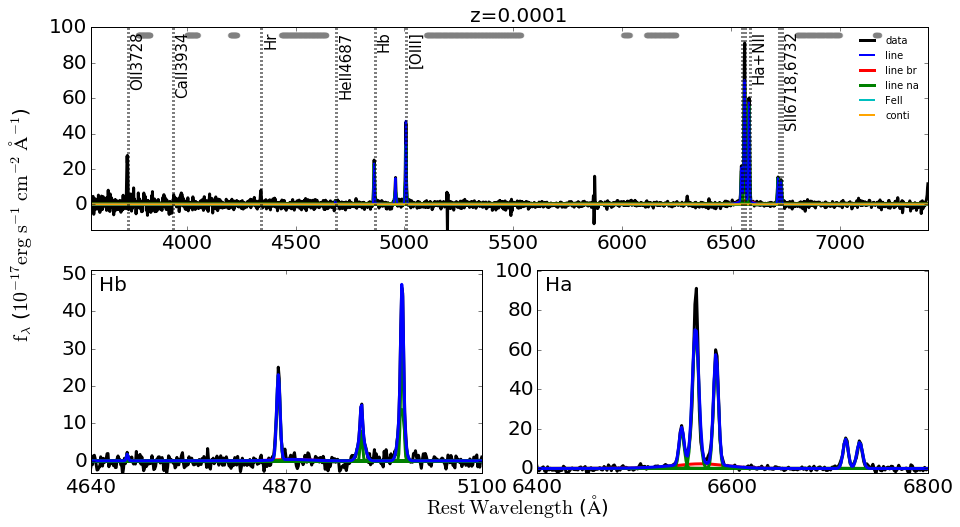

In [76]:
%matplotlib inline
from astropy.cosmology import FlatLambdaCDM
from time import clock
from os import path
import glob, os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.miles_util as lib
from SpecFit import QSOFit
path ='/Users/legolason/study/otherwork/meicun/'

data = np.genfromtxt('/Users/legolason/study/otherwork/meicun/10a.txt')
wave = data[:,0]
line_flux = data[:,1]
err = data[:,2]
q = QSOFit(wave,line_flux,err,0.0001,path=path)
q.Fit(decomposition_host=False,poly=False,and_or_mask=False,deredden=True,
      reject_badpix=False,tie_lambda=False,tie_width=False)

print "Hb, flux, err: ", "129.6853, 15.3321"
print "[OIII]5007, flux, err","228.2456, 30.0012"
print "ha, flux, err", "377.3465, 50.1232"
print "NII6585, flux, err", "239.2026, 20.7782"


Hb, flux, err:  111.6445,8.2234
[OIII]5007, flux, err 264.2254, 12.2334
ha, flux, err 398.8239,49.3425
NII6585, flux, err 181.9845, 10.2232


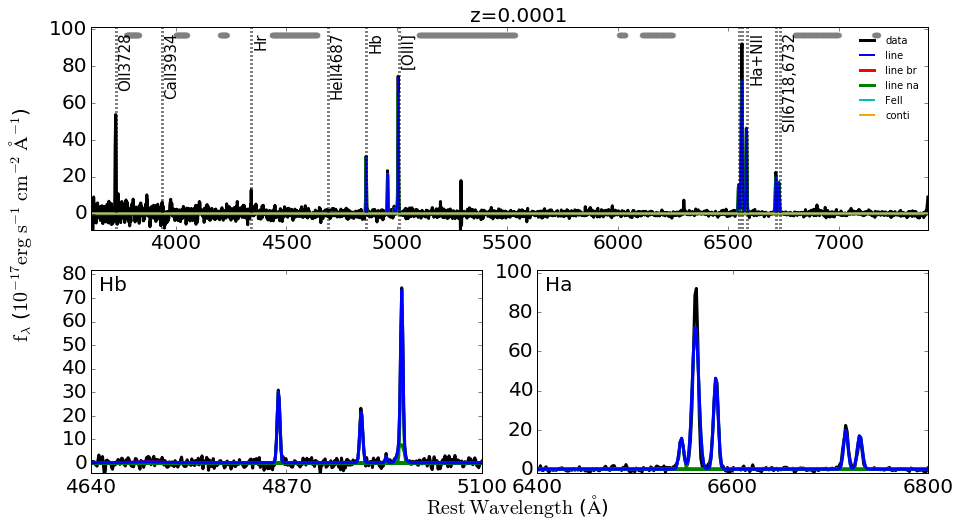

In [77]:
data = np.genfromtxt('/Users/legolason/study/otherwork/meicun/13b.txt')
wave = data[:,0]
line_flux = data[:,1]
err = data[:,2]
q = QSOFit(wave,line_flux,err,0.0001,path=path)
q.Fit(decomposition_host=False,poly=False,and_or_mask=False,deredden=True,
      reject_badpix=False,tie_lambda=False,tie_width=False)

print "Hb, flux, err: ", "111.6445,8.2234"
print "[OIII]5007, flux, err","264.2254, 12.2334"
print "ha, flux, err", "398.8239,49.3425"
print "NII6585, flux, err", "181.9845, 10.2232"

62.286195980228015

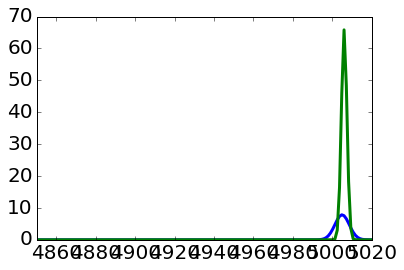

In [75]:
def onegauss(xval, pp):
    """The single Gaussian model used to fit the emission lines 
    Parameter: the scale factor, central wavelength in logwave, line FWHM in logwave
    """
    
    term1 = np.exp( - (xval - pp[1])**2 / (2. * pp[2]**2) )
    yval = pp[0] * term1 / (np.sqrt(2.*np.pi) * pp[2])
    return yval
def manygauss(xval, pp):
    """The multi-Gaussian model used to fit the emission lines, it will call the onegauss function"""
    ngauss = int(pp.shape[0])/3
    if ngauss != 0:
        yval = 0.
        for i in range(ngauss):
            yval = yval + onegauss(xval, pp[i*3:(i+1)*3])
        return yval

"hb 9:12"
"OIII 15:18 21:24"
"Ha 39:42"
"NII6585 45:48"
#plt.plot(q.wave,manygauss(np.log(q.wave), q.gauss_result[21:24]))
#plt.plot(q.wave,manygauss(np.log(q.wave), q.gauss_result[15:18]))
#plt.xlim(4850,5020)

#disp=1.e-5
#yy = manygauss(np.log(q.wave),q.gauss_result[21:24])
#np.sum(yy)

[ 1.28455269  1.28415966  1.28376496 ...,  0.76036733  0.76026064
  0.76015323]
Best Fit:       Vel     sigma        h3        h4
 comp. 0:       180        44     0.006    -0.009
chi2/DOF: 116.9
method = capfit ; Jac calls: 6 ; Func calls: 33 ; Status: 2
Nonzero Templates:  2  /  150
Elapsed time in PPXF: 2.40 s


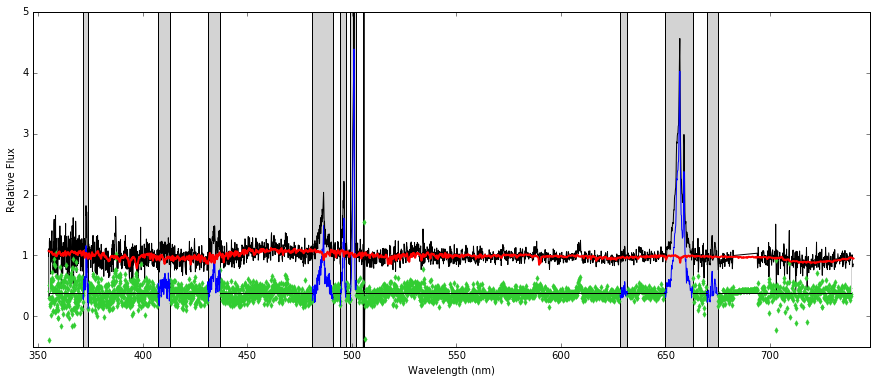

In [11]:
%matplotlib inline
import glob
from time import clock
from os import path

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util



ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))



file = ppxf_dir + '/spectra/spec-0305-51613-0012.fits'
hdu = fits.open(file)
t = hdu['COADD'].data

wave1 = 10**t['loglam']/(1.+ float(hdu[2].data['z']))
flux1 = t['flux']
#err1 = 1./np.sqrt(t['ivar'])
z = 0.

# Only use the wavelength range in common between galaxy and stellar library.
#
mask = np.where( (wave1 > 3550.) & (wave1 < 7400.), True, False)

flux = flux1[mask]
galaxy = flux/np.median(flux)   # Normalize spectrum to avoid numerical issues
lam_gal = wave1[mask]
noise = np.full_like(galaxy, 0.0166)




c = 299792.458                  # speed of light in km/s
frac = lam_gal[1]/lam_gal[0]    # Constant lambda fraction per pixel
dlam_gal = (frac - 1)*lam_gal   # Size of every pixel in Angstrom
wdisp = t['wdisp'][mask]        # Intrinsic dispersion of every pixel, in pixels units
fwhm_gal = 2.355*wdisp*dlam_gal # Resolution FWHM of every pixel, in Angstroms
velscale = np.log(frac)*c       # Constant velocity scale in km/s per pixel

print wdisp

# If the galaxy is at significant redshift, one should bring the galaxy
# spectrum roughly to the rest-frame wavelength, before calling pPXF
# (See Sec2.4 of Cappellari 2017). In practice there is no
# need to modify the spectrum in any way, given that a red shift
# corresponds to a linear shift of the log-rebinned spectrum.
# One just needs to compute the wavelength range in the rest-frame
# and adjust the instrumental resolution of the galaxy observations.
# This is done with the following three commented lines:
#
# lam_gal = lam_gal/(1+z)  # Compute approximate restframe wavelength
# fwhm_gal = fwhm_gal/(1+z)   # Adjust resolution in Angstrom

# Read the list of filenames from the Single Stellar Population library
# by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
# of the library is included for this example with permission
vazdekis = glob.glob(ppxf_dir + '/miles_models/Mun1.30Z*.fits')
fwhm_tem = 2.51 # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.

# Extract the wavelength range and logarithmically rebin one spectrum
# to the same velocity scale of the SDSS galaxy spectrum, to determine
# the size needed for the array which will contain the template spectra.
#
hdu = fits.open(vazdekis[0])
ssp = hdu[0].data
h2 = hdu[0].header
lam_temp = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])
lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
templates = np.empty((sspNew.size, len(vazdekis)))


# Interpolates the galaxy spectral resolution at the location of every pixel
# of the templates. Outside the range of the galaxy spectrum the resolution
# will be extrapolated, but this is irrelevant as those pixels cannot be
# used in the fit anyway.
fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)


# Convolve the whole Vazdekis library of spectral templates
# with the quadratic difference between the SDSS and the
# Vazdekis instrumental resolution. Logarithmically rebin
# and store each template as a column in the array TEMPLATES.

# Quadratic sigma difference in pixels Vazdekis --> SDSS
# The formula below is rigorously valid if the shapes of the
# instrumental spectral profiles are well approximated by Gaussians.
#
# In the line below, the fwhm_dif is set to zero when fwhm_gal < fwhm_tem.
# In principle it should never happen and a higher resolution template should be used.
#
fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
sigma = fwhm_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

for j, fname in enumerate(vazdekis):
    
    hdu = fits.open(fname)
    ssp = hdu[0].data
    ssp = util.gaussian_filter1d(ssp, sigma)  # perform convolution with variable sigma
    sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
    templates[:, j] = sspNew/np.median(sspNew) # Normalizes templates

# The galaxy and the template spectra do not have the same starting wavelength.
# For this reason an extra velocity shift DV has to be applied to the template
# to fit the galaxy spectrum. We remove this artificial shift by using the
# keyword VSYST in the call to PPXF below, so that all velocities are
# measured with respect to DV. This assume the redshift is negligible.
# In the case of a high-redshift galaxy one should de-redshift its
# wavelength to the rest frame before using the line below (see above).
#
c = 299792.458
dv = np.log(lam_temp[0]/lam_gal[0])*c    # km/s
goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, z, 'QSO')

# Here the actual fit starts. The best fit is plotted on the screen.
# Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
#
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.]  # (km/s), starting guess for [V, sigma]
tt = clock()

pp = ppxf(templates, galaxy, noise, velscale, start,
          goodpixels=goodpixels,plot=False, moments=4,
          degree=10, vsyst=dv, clean=False, lam=lam_gal)

plt.figure(figsize=(15,6))
pp.plot()
plt.plot(lam_gal[goodpixels],galaxy[goodpixels])
plt.ylim(-0.5,5)
#print("Formal errors:")
#print("     dV    dsigma   dh3      dh4")
#print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

print('Elapsed time in PPXF: %.2f s' % (clock() - tt))





/Users/legolason/study/otherwork/meicun/data_line/0805+2818a.txt
/Users/legolason/study/otherwork/meicun/data_line/0805+2818b.txt
/Users/legolason/study/otherwork/meicun/data_line/0907+5203a.txt
/Users/legolason/study/otherwork/meicun/data_line/0907+5203b.txt
/Users/legolason/study/otherwork/meicun/data_line/1058+3144a.txt
/Users/legolason/study/otherwork/meicun/data_line/1058+3144b.txt
/Users/legolason/study/otherwork/meicun/data_line/1330-0036a.txt
/Users/legolason/study/otherwork/meicun/data_line/1330-0036b.txt
/Users/legolason/study/otherwork/meicun/data_line/1544+0446a.txt
/Users/legolason/study/otherwork/meicun/data_line/1544+0446b.txt


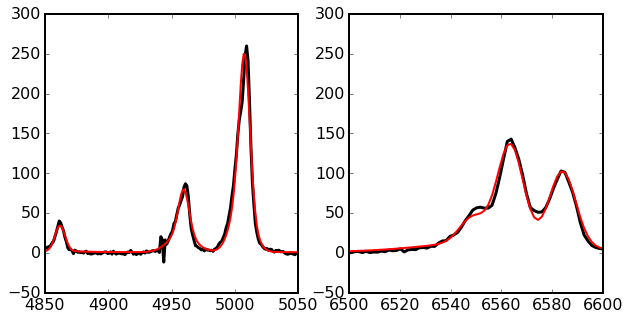

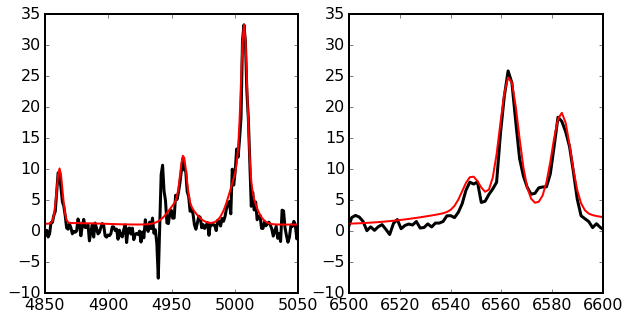

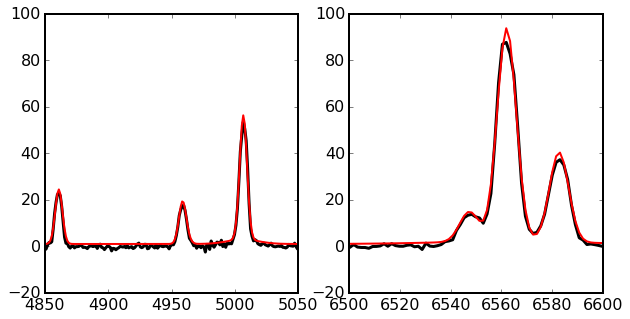

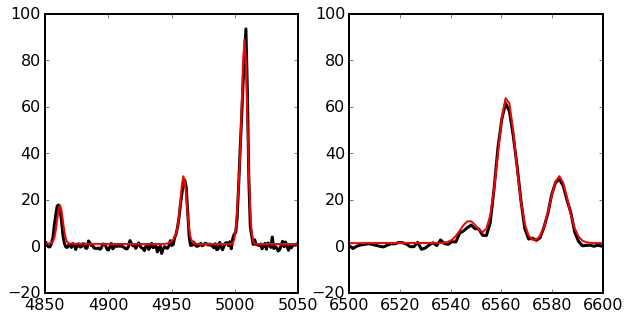

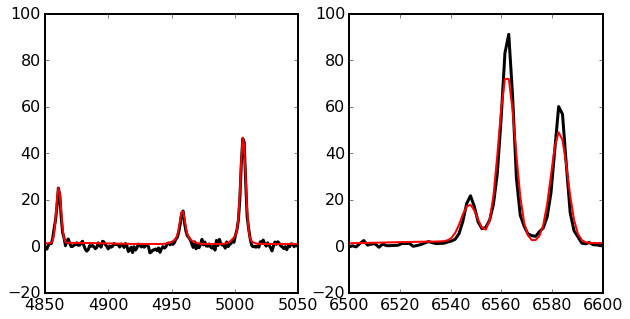

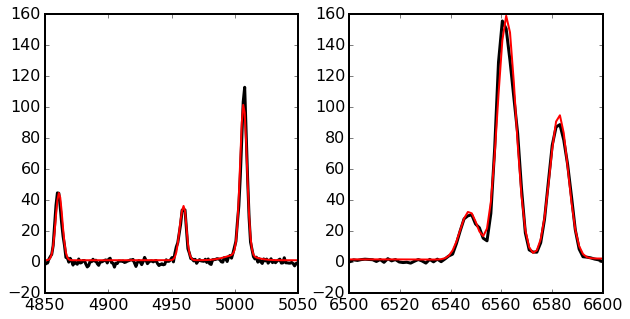

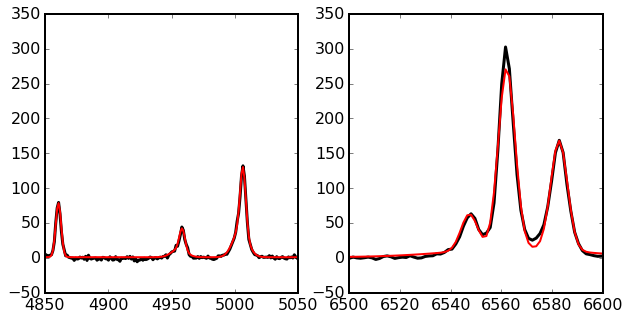

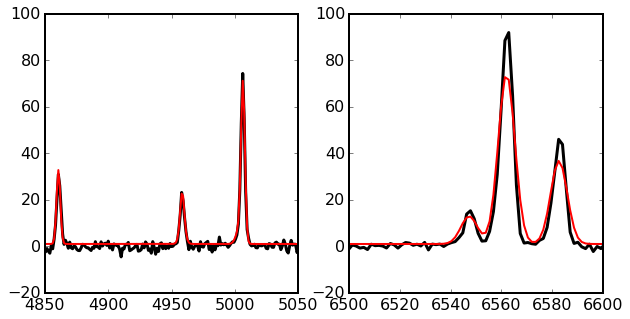

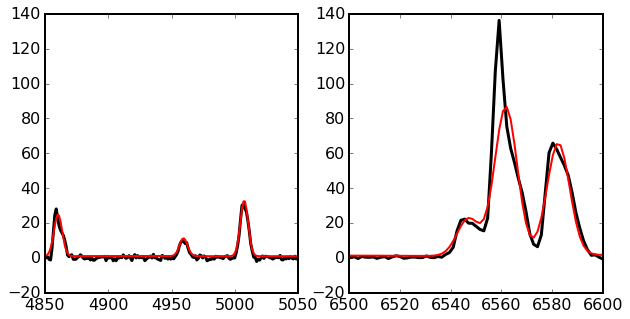

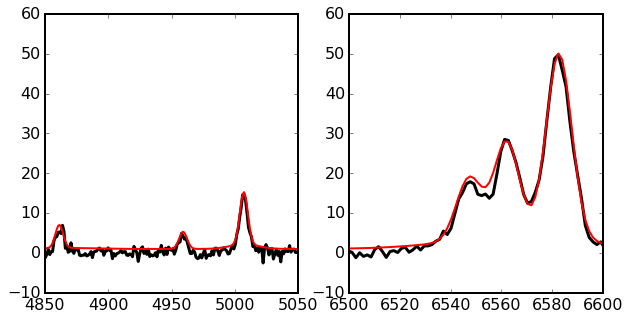

In [65]:
#emission line fitting for all objects
%matplotlib inline
from astropy.cosmology import FlatLambdaCDM
from time import clock
from os import path
import glob, os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.miles_util as lib
from SpecFit import QSOFit
path ='/Users/legolason/study/otherwork/meicun/'

for i in glob.glob('/Users/legolason/study/otherwork/meicun/data_line/??????????.txt'):
    print i
    data = np.genfromtxt(i)

    wave = data[:,0]
    line_flux = data[:,1]
    err = data[:,2]

    q = QSOFit(wave,line_flux,err,0.0001,path=path)
    q.Fit(name = None,nsmooth = 1, and_or_mask = False, deredden = True, reject_badpix = False, wave_range = None,\
          wave_mask =None, decomposition_host = False, Mi = None, npca_gal = 5, npca_qso = 20, \
          Fe_uv_op = True, poly = False, BC = False, rej_abs = False, initial_guess = None, MC = False, \
          n_trails = 5, linefit = True, tie_lambda = True, tie_width = True, tie_flux_1 = True, tie_flux_2 = True,\
          save_result = False, plot_fig = False,save_fig = False, plot_line_name = True, plot_legend = True, \
          dustmap_path = path, save_fig_path = path, save_fits_path = path,save_fits_name = None)
    fig=plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.plot(q.wave,q.flux,'k') 
    plt.plot(q.wave,q.Manygauss(np.log(q.wave),q.gauss_result)+1.,'r',label='line',lw=2)
    plt.xlim(4850,5050)
    
    plt.subplot(122)
    plt.plot(q.wave,q.flux,'k') 
    plt.plot(q.wave,q.Manygauss(np.log(q.wave),q.gauss_result)+1.,'r',label='line',lw=2)
    plt.xlim(6500,6600)
    np.savetxt('/Users/legolason/study/otherwork/meicun/data_line/line_'+i[50:],np.c_[q.wave,q.flux,q.Manygauss(np.log(q.wave),q.gauss_result)])